In [1]:
import numpy as np
from qutip.qip.models.optpulseprocessor import OptPulseProcessor
from qutip.qip.models.spinchain import LinearSpinChain
from qutip.qip import QubitCircuit
from qutip.operators import sigmaz, sigmax, identity
from qutip.tensor import tensor
from qutip.states import basis
from qutip.qobj import ptrace
basis00 = tensor([basis(2,0), basis(2,0)])

Based on my branch https://github.com/BoxiLi/qutip/tree/qip_opt

## The Deutsch–Jozsa algorithm
The Deutsch–Jozsa algorithm is the simplest quantum algorithm that offers an exponential speed-up compared to the classical one. It assumes that we have a function $f:\{0,1\}^n \rightarrow \{0,1\}$ which is either balanced or constant. Constant means that $f(x)$ is either 1 or 0 for all inputs while balanced means that $f(x)$ is 1 for half of the input domain and 0 for the other half. A more rigorous definition can be found at https://www.wikiwand.com/en/Deutsch%E2%80%93Jozsa_algorithm. 

The implementation of the Deutsch–Jozsa algorithm clues $n$ input qubits and 1 ancilla initialised in state $1$. At the end of the algorithm, the first $n$ qubits are measured on the computational basis. If the function is constant, the result will be $0$ for all $n$ qubits. If balanced, $\left|00...0\right\rangle$ will never be measured.
The following example is implmented for the balenced function $f:\{00,01,10,11\} \rightarrow \{0,1\}$, where $f(00)=f(11)=0$ and $f(01)=f(10)=1$. This function is balanced, so the probability of measuring state $\left|00\right\rangle$ should be 0.

In [2]:
qc = QubitCircuit(N=3)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("SNOT", targets=2)

# function f(x)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("CNOT", controls=1, targets=2)

qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)

## With OptPulseProcessor

In [3]:
proc = OptPulseProcessor(N=3)
proc.add_ctrl(sigmaz(), cyclic_permutation=True)
proc.add_ctrl(sigmax(), cyclic_permutation=True)
proc.add_ctrl(tensor([sigmax(), sigmax(), identity(2)]))
proc.add_ctrl(tensor([identity(2), sigmax(), sigmax()]))
proc.load_circuit(qc, n_ts=10, evo_time=5, verbose=True, amp_ubound=5, amp_lbound=0);

********** Gate 0 **********
Final fidelity error 5.103973202191803e-06
Final gradient normal 0.0006441113610650829
Terminated due to function converged
Number of iterations 70
********** Gate 1 **********
Final fidelity error 2.3455669669991686e-05
Final gradient normal 0.00195093770569959
Terminated due to function converged
Number of iterations 46
********** Gate 2 **********
Final fidelity error 3.801708392536796e-09
Final gradient normal 4.451636819971288e-05
Terminated due to function converged
Number of iterations 71
********** Gate 3 **********
Final fidelity error 9.503703134461361e-07
Final gradient normal 0.0005094646136939223
Terminated due to function converged
Number of iterations 81
********** Gate 4 **********
Final fidelity error 8.518734360141167e-07
Final gradient normal 0.00021245546768704202
Terminated due to function converged
Number of iterations 57
********** Gate 5 **********
Final fidelity error 7.052379269456566e-07
Final gradient normal 7.10248862355446e-05


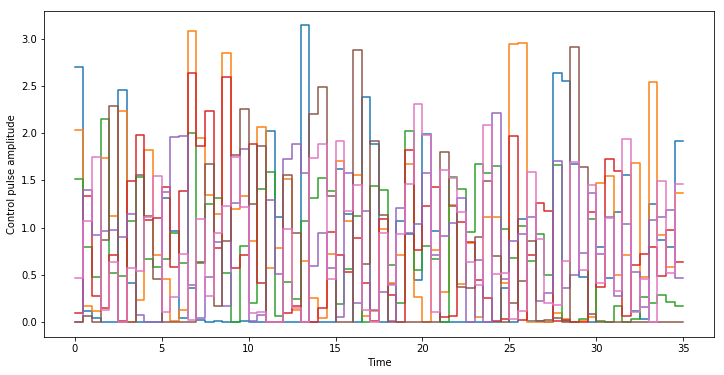

In [4]:
proc.plot_pulses()

In [5]:
# Without decoherence
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc.run_state(rho0=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
3.989908890274493e-06


In [6]:
# With decoherence
proc.T1 = 100
proc.T2 = 30
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc.run_state(rho0=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.21615952283395506


## With SpinChain

In [7]:
proc2 = LinearSpinChain(3)
proc2.load_circuit(qc);

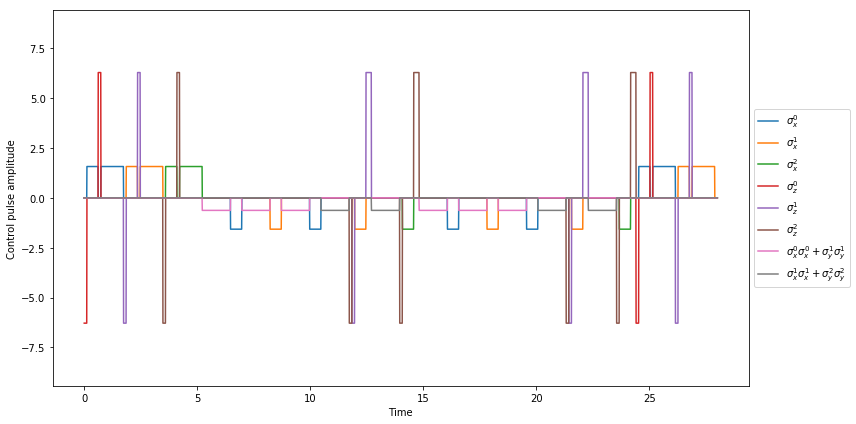

In [8]:
proc2.plot_pulses();

In [9]:
# Without decoherence
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc2.run_state(rho0 = psi0, numerical=True)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
1.8002112771931593e-09


In [10]:
# With decoherence
proc2.T1 = 100
proc2.T2 = 30
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = proc2.run_state(rho0 = psi0, numerical=True)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.1661582845316164
